Goal is to create a domain adaptation problem that is theoretically very easy. Our architecture should at minimum show reasonable loss curves and performance in this case.

In [1]:
import random
import os

from domain_adaptation_ct.dataset.image_dataset import TwoLabelDataset
from domain_adaptation_ct.visualize.imshow_gray import ImShowGray

import numpy as np
import matplotlib.pyplot as plt




In [2]:
full_val_dataset = TwoLabelDataset.load("/data/D21_preprocessed/D21_preprocessed_val_v2.npz", convert_grayscale_to_rgb=True)

In [3]:
# Estimate size of validation dataset
full_val_dataset[0]['pixel_values'].nbytes * len(full_val_dataset) / ((2**10)**3) # ~7 GB

7.279792785644531

In [4]:
# Understand shape of existing validation dataset
print("Image shape:", full_val_dataset.images.shape)
print("Labels1 shape:", full_val_dataset.labels1.shape)
print("Labels2 shape:", full_val_dataset.labels2.shape)

Image shape: (12982, 224, 224)
Labels1 shape: (12982, 1)
Labels2 shape: (12982, 1)


In [5]:
# Our preprocessed data is already shuffled. We use cross validation, so using validation set for investigation here is okay
# Treat as a 3-class problem. This dataset is known to only be original images (d=0) and ring images (d=1)
# Split into 5 folds.
toy_dataset_mask = (full_val_dataset.labels1 >= 8).flatten()

toy_num_samples = toy_dataset_mask.sum()
print(toy_num_samples)

toy_num_folds = 5
toy_est_fold_size = toy_num_samples // toy_num_folds

toy_fold_datasets = [
    TwoLabelDataset(
        images = full_val_dataset.images[toy_dataset_mask][(i*toy_est_fold_size):((i+1)*toy_est_fold_size)],
        labels1 = full_val_dataset.labels1[toy_dataset_mask][(i*toy_est_fold_size):((i+1)*toy_est_fold_size)],
        labels2 = full_val_dataset.labels2[toy_dataset_mask][(i*toy_est_fold_size):((i+1)*toy_est_fold_size)],
        convert_grayscale_to_rgb = False, # doesn't matter in this context
    ) for i in range(toy_num_folds)
]

4098


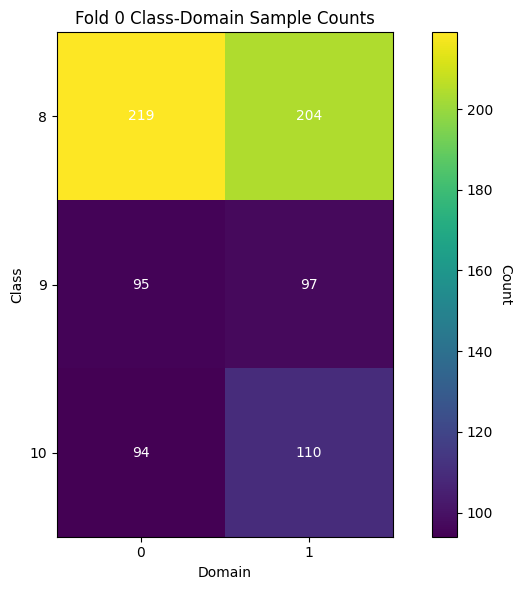

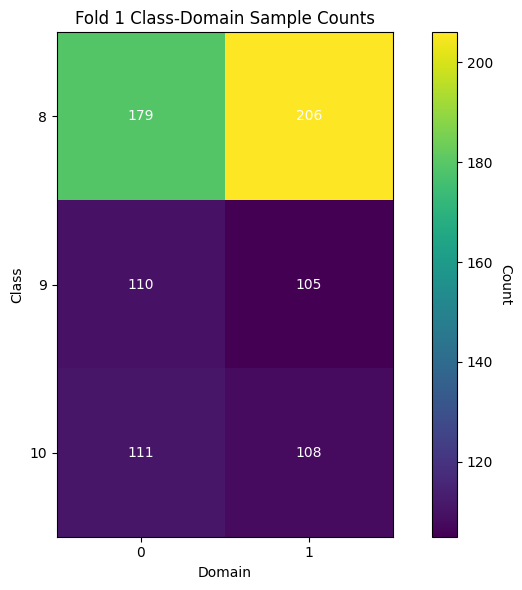

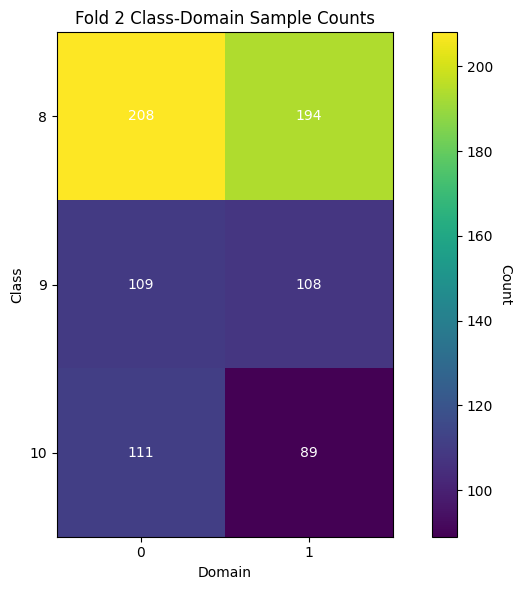

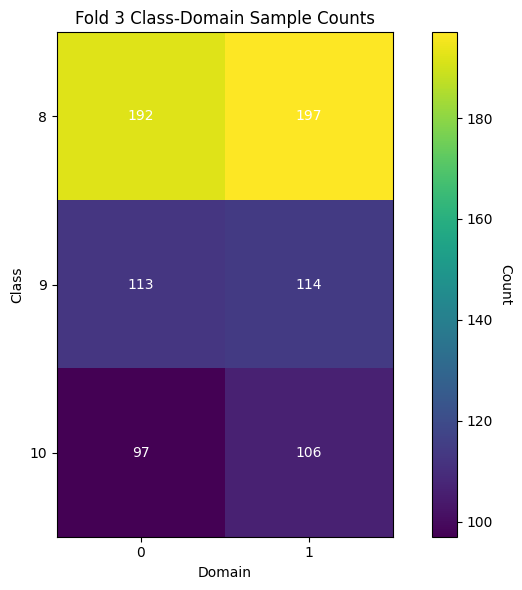

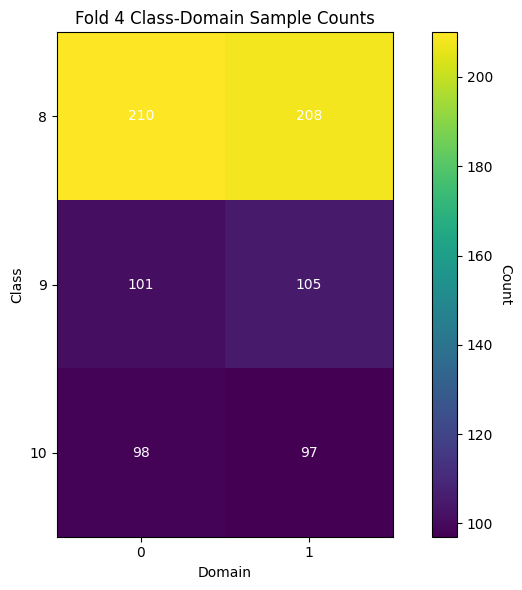

In [6]:
def plot_class_domain_heatmap(dataset, fold_num):
    """
    Display a heatmap showing counts for each combination of class and domain.

    Parameters:
    - dataset: An object with attributes `labels1` (classes) and `labels2` (domains)
    - class_label_name: Label for the class axis
    - domain_label_name: Label for the domain axis
    """
    classes = np.unique(dataset.labels1)
    domains = np.unique(dataset.labels2)

    # Initialize count matrix
    heatmap = np.zeros((len(classes), len(domains)), dtype=int)

    # Count occurrences
    for c, d in zip(dataset.labels1, dataset.labels2):
        c_idx = np.where(classes == c)[0][0]
        d_idx = np.where(domains == d)[0][0]
        heatmap[c_idx, d_idx] += 1

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(heatmap, cmap="viridis")

    # Add colorbar
    cbar = ax.figure.colorbar(im, ax=ax)

    class_label_name="Class"
    domain_label_name="Domain"
    cbar.ax.set_ylabel("Count", rotation=-90, va="bottom")

    # Set ticks and labels
    ax.set_xticks(np.arange(len(domains)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(domains)
    ax.set_yticklabels(classes)
    ax.set_xlabel(domain_label_name)
    ax.set_ylabel(class_label_name)
    ax.set_title(f"Fold {fold_num} Class-Domain Sample Counts")

    # Annotate cells
    for i in range(len(classes)):
        for j in range(len(domains)):
            ax.text(j, i, heatmap[i, j], ha="center", va="center", color="white")

    plt.tight_layout()
    plt.show()

for fold_num in range(len(toy_fold_datasets)):
    plot_class_domain_heatmap(toy_fold_datasets[fold_num], fold_num)

# seems ballpark good enough to work with. roughly stratified, and should be able to check effects of class imbalance

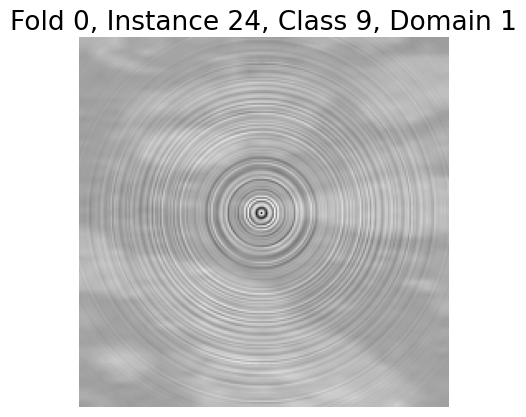

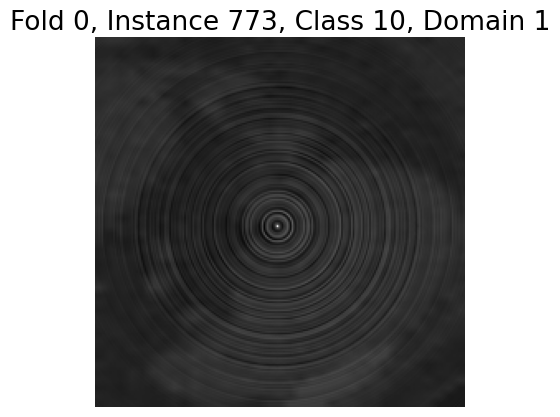

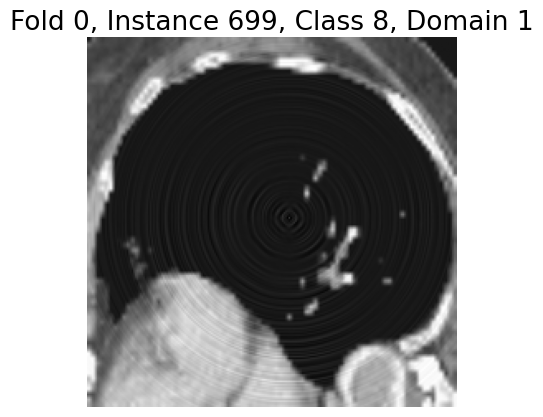

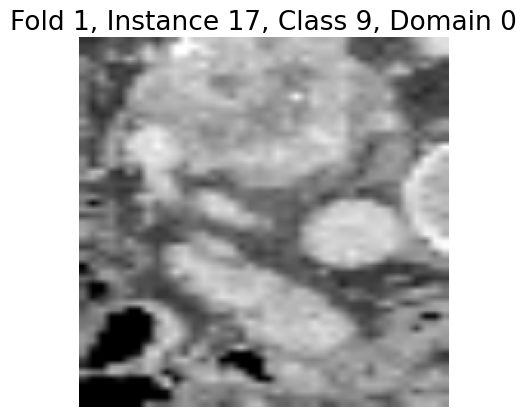

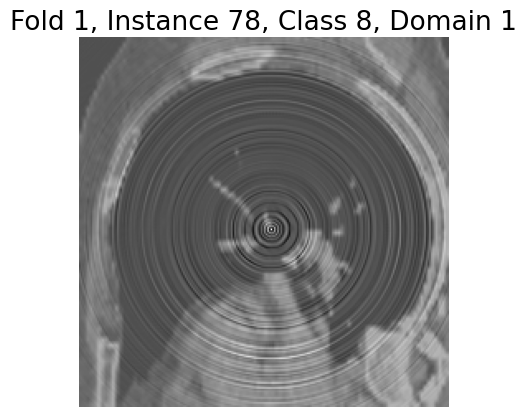

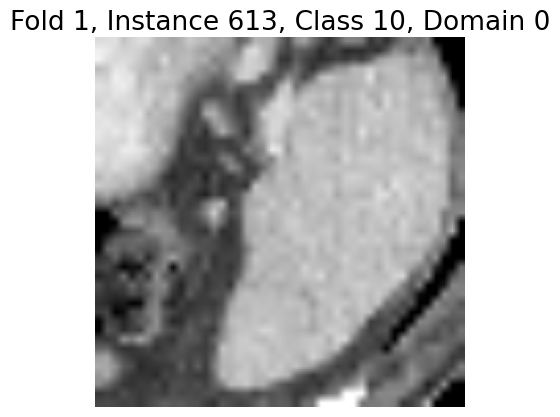

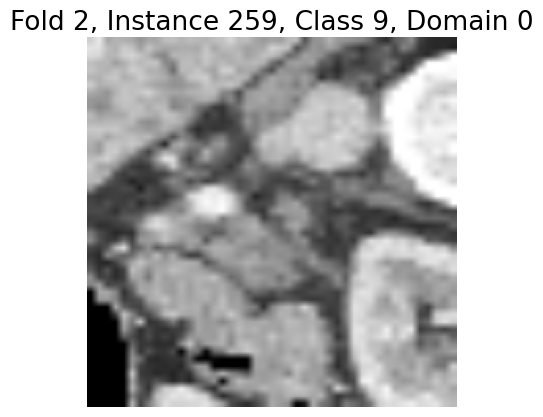

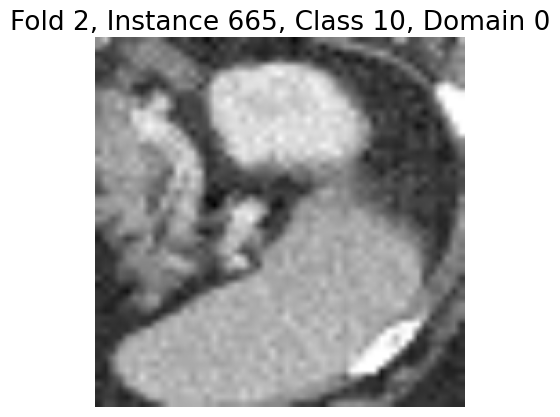

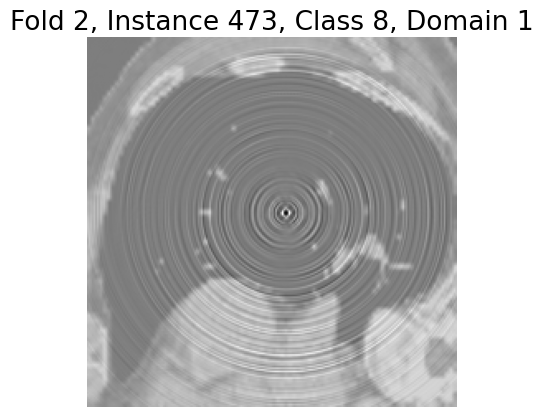

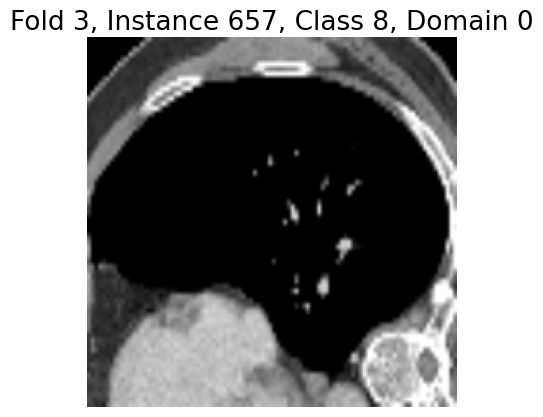

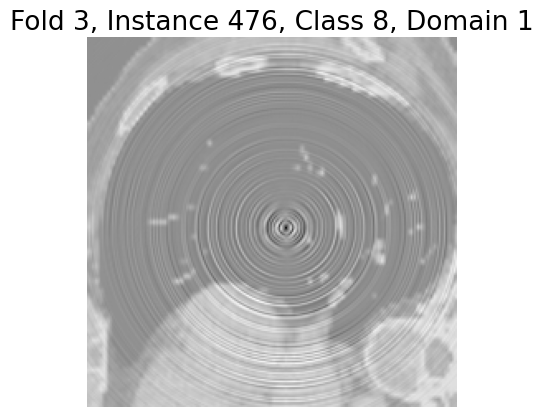

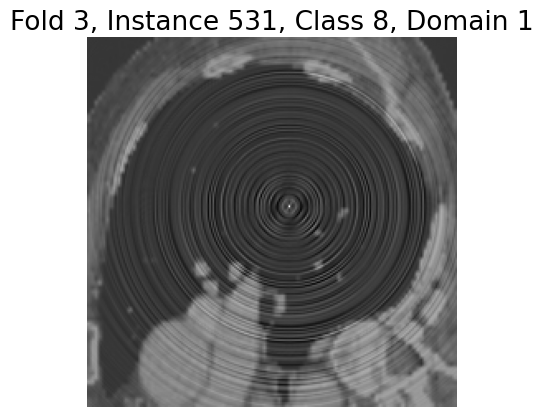

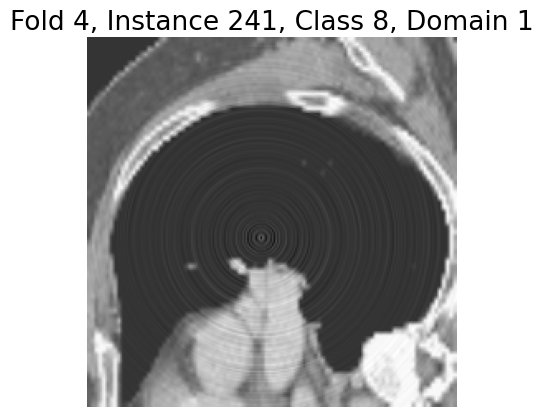

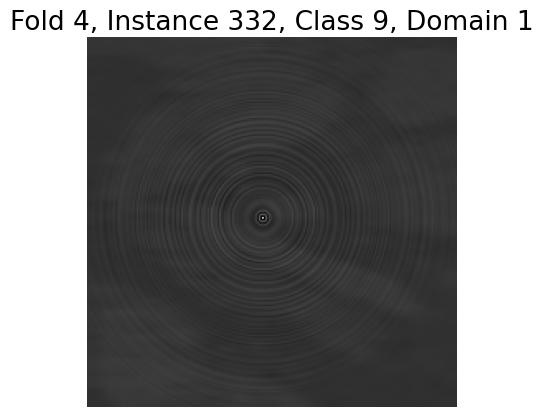

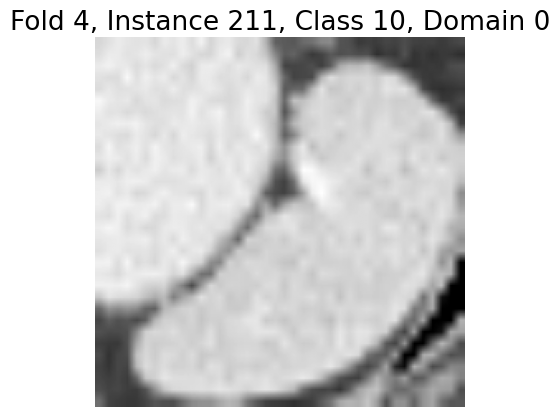

In [7]:
# Quick check that images seem correctly associated with labels
for fold_num in range(len(toy_fold_datasets)):
    for i in range(3):
        sample_num = random.randint(0, toy_est_fold_size-1) # Don't need to seed, want to see random sampling of images
        sample = toy_fold_datasets[fold_num][sample_num]
        ImShowGray.imshow(sample['pixel_values'].squeeze(), title=f"Fold {fold_num}, Instance {sample_num}, Class {sample['labels1']}, Domain {sample['labels2']}")

In [ ]:
os.makedirs("/data/toy/", exist_ok=True)
for fold_num in range(len(toy_fold_datasets)):
    toy_fold_datasets[fold_num].save(f"/data/toy/fold{fold_num}.npz")